In [1]:
# Import PyTorch Data Loader Library
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Other Library Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
import SimpleITK as sitk
import nibabel as nib

# Custom Imports
from DRAC_Test_Dataloading import DRAC_Test_Loader

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA RTX A5000


In [3]:
batch_size = 16

In [4]:
# Load in the custom models
name = os.listdir("./models/")

# Print out items with structure "#. model_name"
for i in range(len(name)):
    print(f"{i}. {name[i]}")

0. UNet-Monai-Simplified_6_50_MonaiDice
1. UNet-Monai-Simplified_16_50_MonaiDice
2. UNet-Monai_16_35_MonaiDice
3. fcn_resnet50_3_250_DiceLoss
4. fcn_resnet50_2_100_CrossEntropyLoss
5. UNet-Monai_8_5_MonaiDice
6. fcn_resnet50_3_250_DiceLoss_1
7. UNet-Monai-Simplified_16_350_MonaiDice
8. fcn_resnet50_2_50_CrossEntropyLoss
9. UNet-Monai_16_200_MonaiDice


In [5]:
file = "./models/" + name[0] + "/"
models = os.listdir(file)
models = [file + model for model in models]

# If any item in the list is a directory, remove it
models = [model for model in models if not os.path.isdir(model)]

# Get the folder name
folder_name = file.split("/")[-2]

models, folder_name

(['./models/UNet-Monai-Simplified_6_50_MonaiDice/model_Intraretinal.pt',
  './models/UNet-Monai-Simplified_6_50_MonaiDice/model_Neovascularization.pt',
  './models/UNet-Monai-Simplified_6_50_MonaiDice/model_Nonperfusion.pt'],
 'UNet-Monai-Simplified_6_50_MonaiDice')

In [6]:
# Within file create folder called "Predictions"
if not os.path.exists(file + "Predictions"):
    os.makedirs(file + "Predictions")

# Set another location
predictions = file + "Predictions/"

In [7]:
# Use os to list all items in following directory
directory = "./data/Segmentation/Original/test/"
items = os.listdir(directory)

# Item Locations
item_locations = [directory + item for item in items]

item_locations[:4]

['./data/Segmentation/Original/test/1250.png',
 './data/Segmentation/Original/test/1281.png',
 './data/Segmentation/Original/test/728.png',
 './data/Segmentation/Original/test/1172.png']

In [8]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

In [9]:
test_dataset = DRAC_Test_Loader(data = item_locations, data_names = items, transform = transforms)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [10]:
# Get shape of the image
image = test_dataset[0]

image

{'image': tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.9529, 0.9961, 0.9412],
          [0.0039, 0.0039, 0.0039,  ..., 0.3922, 0.4980, 0.5294],
          [0.0039, 0.0039, 0.0039,  ..., 0.1294, 0.1647, 0.5686],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.3137, 0.3412, 0.2314],
          [0.0039, 0.0039, 0.0039,  ..., 0.1804, 0.1373, 0.1255],
          [0.0039, 0.0039, 0.0039,  ..., 0.1922, 0.0039, 0.0118]]])}

In [11]:
count = 0

for model_location in models:
    model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
).to(device)
    
    # Trained model is located at model_location, load this
    model.load_state_dict(torch.load(model_location))
    
    model.eval()
    
    # Test the model, run if statements...
    if "Intraretinal" in model_location:
        loader = test_dataloader
        loader_name = "Intraretinal"
        nii_file = "1.nii.gz"
    elif "Neovascularization" in model_location:
        loader = test_dataloader
        loader_name = "Neovascularization"
        nii_file = "3.nii.gz"
    elif "Nonperfusion" in model_location:
        loader = test_dataloader
        loader_name = "Nonperfusion"
        nii_file = "2.nii.gz"
    else:
        print("Error")
        break
    
    # Create a list to store all outputs
    all_outputs = []
    
    threshold = 0.5
    for data in loader:
        inputs = data["image"].to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
        outputs = (outputs > threshold).float()  # This will give you a tensor of 0s and 1s
        all_outputs.append(outputs.cpu().numpy())  # No need to divide by 255
        
    final_output = np.concatenate(all_outputs, axis = 0)
    
    # Save the output array to a NIfTI file
    nii_img = nib.Nifti1Image(final_output, np.eye(4))  # Adjust affine as necessary
    nib.save(nii_img, f'{predictions}{nii_file}')
    print(f"The model for {loader_name} has been saved as {nii_file} in {predictions}")

The model for Intraretinal has been saved as 1.nii.gz in ./models/UNet-Monai-Simplified_6_50_MonaiDice/Predictions/
The model for Neovascularization has been saved as 3.nii.gz in ./models/UNet-Monai-Simplified_6_50_MonaiDice/Predictions/
The model for Nonperfusion has been saved as 2.nii.gz in ./models/UNet-Monai-Simplified_6_50_MonaiDice/Predictions/


In [12]:
# Load "./models/fcn_resnet50_2_50_CrossEntropyLoss/Predictions/1.nii.gz"
images = [sitk.ReadImage(f"{predictions}1.nii.gz"), sitk.ReadImage(f"{predictions}2.nii.gz"), sitk.ReadImage(f"{predictions}3.nii.gz")]
images

[<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f2981ffd9e0> >,
 <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f2981ffda10> >,
 <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f2981fffc00> >]

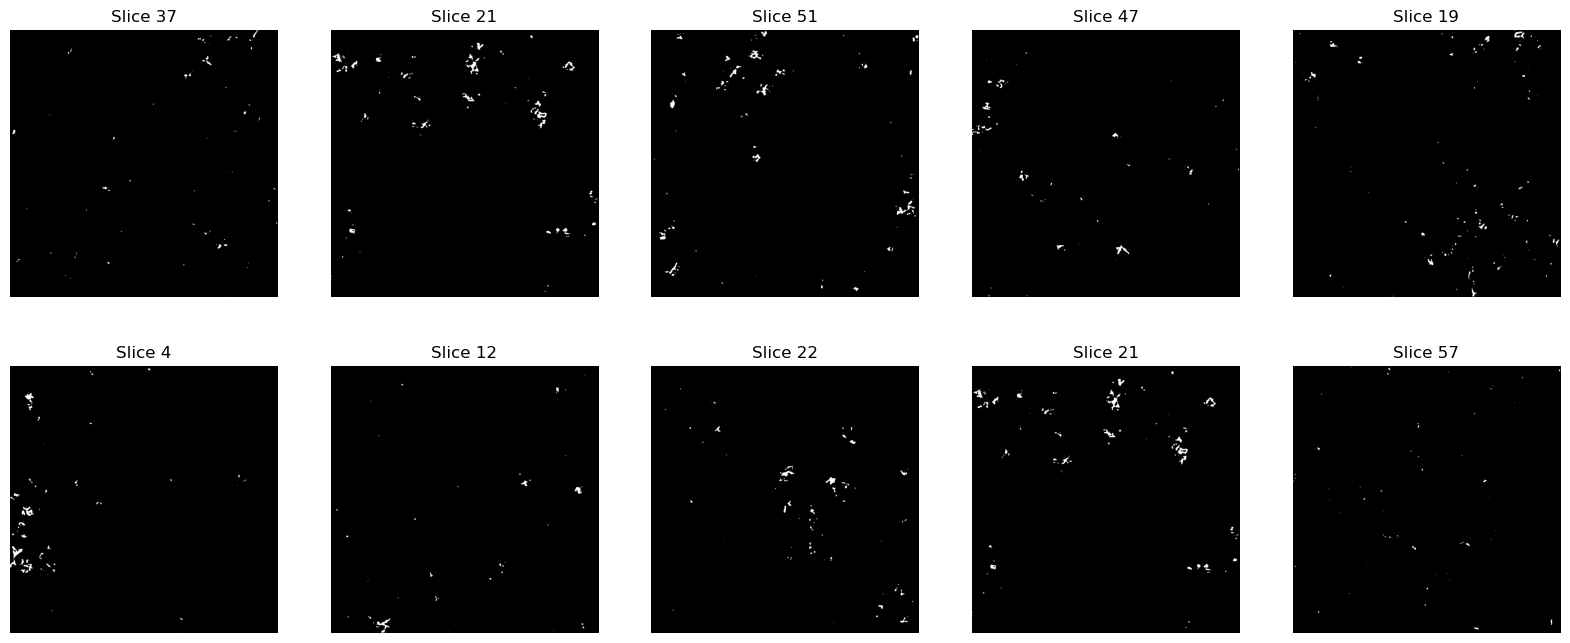

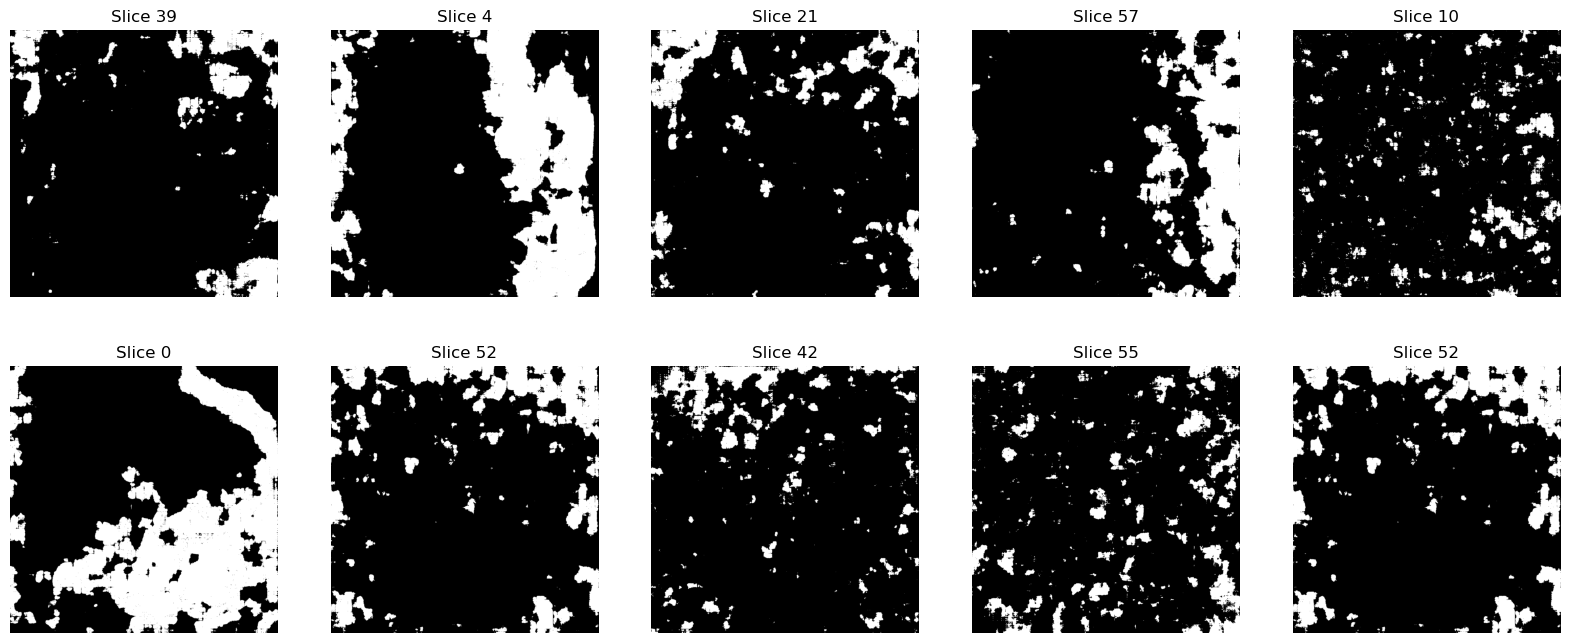

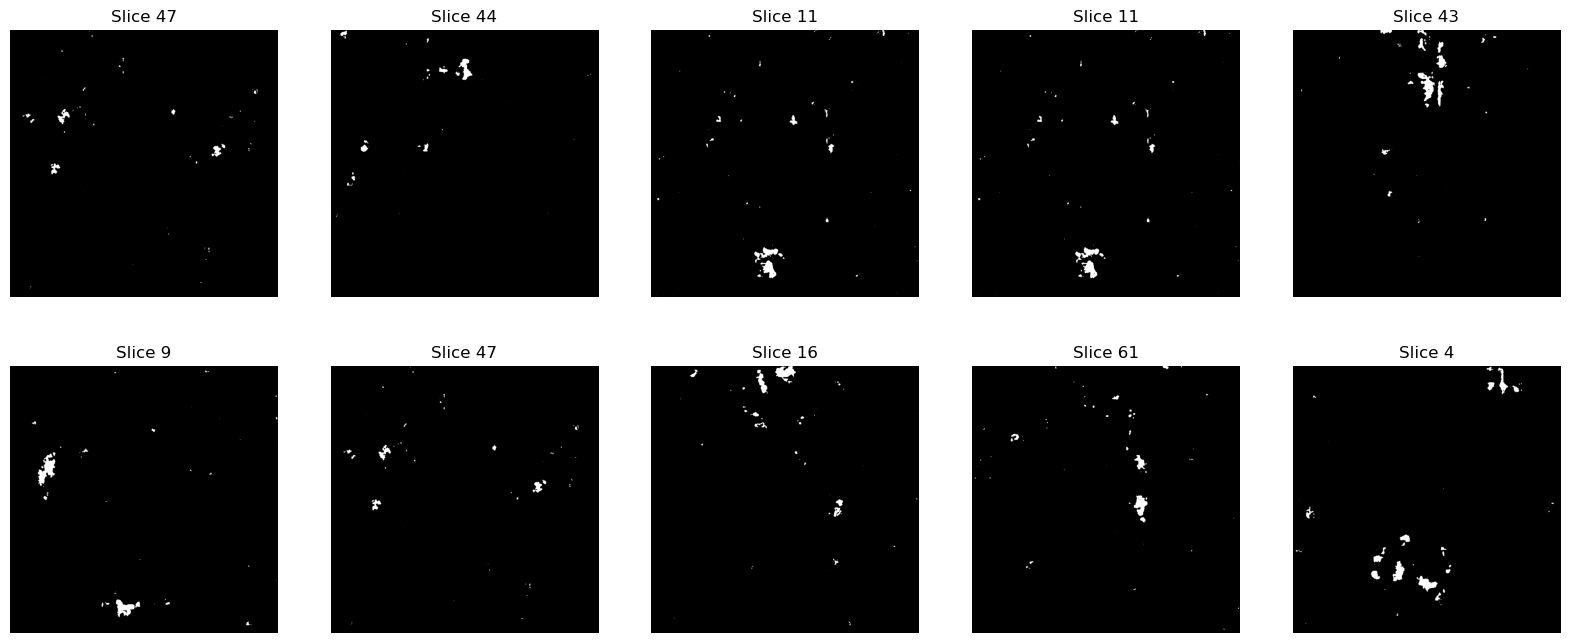

In [18]:
mask_names = ["Intraretinal", "Nonperfusion", "Neovascularization"]
count = 0

# For each item in images:
for image in images:
    # Plot 10 random images in a 2x5 grid
    plt.figure(figsize = (20, 8))
    for i in range(10):
        import random
        j = random.randint(0, 64)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(sitk.GetArrayFromImage(image)[:,:,:,j], cmap = 'gray')
        plt.axis('off')
        plt.title(f"Slice {j}")
    # Save plot in the same directory, but instead of Predictions do "Plots"
    if not os.path.exists(file + "Plots"):
        os.makedirs(file + "Plots")
    plt.savefig(f"{file}Plots/{mask_names[0]}.png")
    
    plt.show()
    count+=1

In [14]:
# Load the first image.
image = sitk.ReadImage(f"{predictions}1.nii.gz")
image = sitk.GetArrayFromImage(image)
image

array([[[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.]],



In [15]:
# Get the image dimensions
size = image.GetSize()
print("Image size:", size)

# Get the voxel spacing
spacing = image.GetSpacing()
print("Voxel spacing:", spacing)

# Get the image origin
origin = image.GetOrigin()
print("Image origin:", origin)

# Access the image data as a numpy array
image_array = sitk.GetArrayFromImage(image)
print("Image array shape:", image_array.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'GetSize'